In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qpsolvers

## 1. System dynamics

The system dynamic is
$$
    m\ddot{x} = mg + u_1 + u_2 \tag{1.1}
$$

Let the state variable be 
$$
    q = \left[ \begin{array}{ccc}
        x & \dot{x} & g
        \end{array} \right] ^T \tag{1.2}
$$

The system equation can be written as
$$
    \dot{q} = \left[ \begin{array}{c}
        \dot{x} \\
        \ddot{x} \\
        0
        \end{array} \right] = 
        \left[ \begin{array}{ccc}
        0 & 1 & 0 \\
        0 & 0 & 1 \\
        0 & 0 & 0
        \end{array} \right]
        \left[ \begin{array}{c}
        x \\
        \dot{x} \\
        g
        \end{array} \right] + 
        \left[ \begin{array}{cc}
        0 & 0 \\
        \frac{1}{m} & \frac{1}{m} \\
        0 & 0
        \end{array} \right]
        \left[ \begin{array}{c}
        u_1 \\
        u_2 \\
        \end{array} \right] \tag{1.3}
$$

In [2]:
dt = 0.001
m = 1
gravity = -9.81

DimS = 3
DimU = 2
# q = [x xdot g]'
# qdot = Aq + Bu
# [xdot xddot gdot]' = [0 1 0;
#                       0 0 1;
#                       0 0 0] *  
A = np.array(
    [[0, 1, 0],
     [0, 0, 1],
     [0, 0, 0]])
B = np.array([[0, 0], [1/m, 1/m], [0, 0]])

Ak = np.eye(3) + dt * A
Bk = dt * B

x0 = np.array([0, 0, gravity])
u0 = np.array([0, 0])

sim_total_count = 2000
t = np.zeros(sim_total_count)
x = np.zeros((DimS, sim_total_count))

x[:, 0] = x0

for i in range(1, sim_total_count):
    t[i] = i * dt
    x[:, i] = Ak @ x[:, i-1] + Bk @ u0

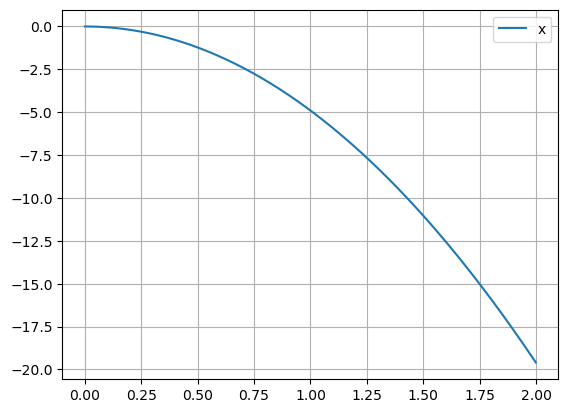

In [3]:
plt.plot(t, x[0,:])
plt.legend(['x'])
plt.grid(True)

## 2. MPC problem formulation

MPC problem is to find an optimal control input to minimize the following cost function:
$$
    \mathop{\min_{u_k} }(\sum_{i=1}^n\left({u_{k+i-1}^T R_k u_{k+i-1} + x_{k+i}^T Q_k x_{k+i}}\right) \\
    \text{s.t.}\\
    x_{k+1} = A_k x_k + B_k u_k,\\
    C_{kx} x_k \leq c_x \\
    C_{ku} u_k \leq c_u \\
    D_{kx} x_k = d_x \\
    D_{ku} u_k = d_u \\ 

$$

The discrete dynamics is obtained by Forward-Euler transformation
$$
A_{k_{mpc}} = I+TA \\
B_{k_{mpc}} = TB
$$
where $T$ is the sampling time of MPC.

In [4]:
leap_mpc = 16
dt_mpc = leap_mpc * dt 
horizon_length = 50

# x_k+1 = A_k_mpc x_k + B_k_mpc u_k 
A_k_mpc = np.eye(DimS) + dt_mpc * A
B_k_mpc = dt_mpc * B

print(A_k_mpc)
print(B_k_mpc)

# Inequality constrains
# C_kx x_k < c_x
C_k_x = None
c_k_x = None
C_k_u = None
c_k_u = None

# Equality constraints
D_k_x = None
d_k_x = None
D_k_u = None
d_k_u = None

# lb < uk < ub
LB_k = np.array([0, 0])
UB_k = np.array([20, 20])

# cost function weights
Q = np.diag([1000, 30, 0])
R = np.diag([0.002, 0.002 ])


[[1.    0.016 0.   ]
 [0.    1.    0.016]
 [0.    0.    1.   ]]
[[0.    0.   ]
 [0.016 0.016]
 [0.    0.   ]]


In [5]:
# Invariant inputs for MPC
# Abar, Bbar 
Abar = np.zeros((DimS*horizon_length, DimS))
Bbar = np.zeros((DimS*horizon_length, DimU*horizon_length))
Abar[0:3,0:3] = Ak

for i in range(1, horizon_length):
    Abar[0+i*DimS:DimS+i*DimS,0:DimS] = Ak @ Abar[0+(i-1)*DimS:DimS+(i-1)*DimS, 0:DimS]

for col in range(0, horizon_length):
    for row in range(0, horizon_length):
        if row < col:
            continue
        elif row == col:
            Bbar[0+row*DimS:DimS+row*DimS, 0+col*DimU:DimU+col*DimU] = Bk
        else:
            Bbar[0+row*DimS:DimS+row*DimS, 0+col*DimU:DimU+col*DimU] \
                 = Ak @ Bbar[0+(row-1)*DimS:DimS+(row-1)*DimS, 0+col*DimU:DimU+col*DimU]

# Qbar, Rbar
Qbar = np.zeros((DimS*horizon_length, DimS*horizon_length))
Rbar = np.zeros((DimU*horizon_length, DimU*horizon_length))

for cr in range(0, horizon_length):
    Qbar[0+cr*DimS:DimS+cr*DimS, 0+cr*DimS:DimS+cr*DimS] = Q
    Rbar[0+cr*DimU:DimU+cr*DimU, 0+cr*DimU:DimU+cr*DimU] = R

# H, GG
H = Rbar + Bbar.T @ Qbar @ Bbar
GG = Abar.T @ Qbar @ Bbar

# LBbar, UBbar
LBbar = np.zeros(DimU*horizon_length)
UBbar = np.zeros(DimU*horizon_length)
for row in range(0, horizon_length):
    LBbar[0+row*DimU:DimU+row*DimU] = LB_k
    UBbar[0+row*DimU:DimU+row*DimU] = UB_k
 

In [6]:
#try solve QP problem

sim_total_count = 10000
t = np.zeros(sim_total_count)
x = np.zeros((DimS, sim_total_count))
ul = np.zeros((DimU, sim_total_count))


x[:, 0] = x0
ul[:, 0] = u0

u_mpc = np.zeros((DimU, horizon_length))

# actual loop
for i in range(1, sim_total_count):
    # print(i)
    t[i] = i * dt

    # solve MPC every mpc_leap cycle
    if (i-1) % leap_mpc == 0:
        Gk = np.reshape(x[:, i-1], (DimS, 1)).T @ GG

        supp = np.zeros((DimU, horizon_length))
        UBbar = np.zeros(DimU*horizon_length)
        # predict support state of the future 
        for j in range(0, horizon_length):
            if np.floor((i + j - 1) / 250) % 2:
                supp[0, j] = 1.0
            else:
                supp[1, j] = 0.0

            UB_k = np.array([1e-4 + 80 * supp[0, j], 1e-4 + 80 * supp[1, j]])
            UBbar[0+j*DimU:DimU+j*DimU] = UB_k

        res = qpsolvers.solve_qp(\
            P=H, q=Gk.flatten(), \
            lb=LBbar.flatten(), ub=UBbar.flatten(), \
            solver="quadprog")
        u_mpc = np.reshape(res, (DimU, horizon_length), order='F')

    # do simulation
    x[:, i] = Ak @ x[:, i-1] + Bk @ u_mpc[:, 0]
    ul[:, i] = u_mpc[:, 0]

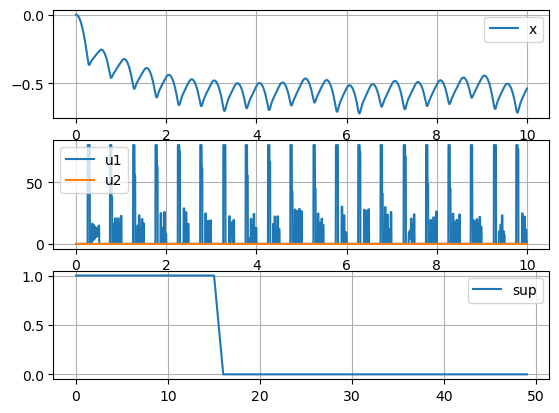

In [7]:
plt.subplot(3,1,1)
plt.plot(t, x[0, :])
plt.legend(['x'])
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, ul[0,:], t, ul[1,:])
plt.legend(['u1','u2'])
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(supp[0,:])
plt.legend(['sup'])
plt.grid(True)

In [8]:
print(res)

[ 1.68151938e+00  1.00000000e-04 -1.11022302e-16  0.00000000e+00
 -3.46497786e-16  0.00000000e+00 -2.16208956e-17 -1.73549810e-20
  1.06004989e-15  6.14629274e-31  8.46459966e-16  2.53611569e-16
 -1.11269282e-15  1.97798519e-16 -3.10155020e-16  1.82811089e-15
 -1.57568224e-15 -3.64567759e-16  3.84141940e-16  1.60474741e-15
 -3.84698735e-15 -7.25774738e-15 -2.47014700e-15  5.35094107e-15
  5.62224854e-15 -1.12291976e-14 -2.49818420e-15 -4.15738481e-18
  5.99929367e-15  1.64146260e-15 -2.67166080e-15 -2.63246510e-15
 -3.67350630e-15  1.03603320e-14 -5.44086933e-15  8.39974506e-15
 -1.27089202e-14 -2.80097847e-15 -2.90512413e-15 -4.89302693e-17
 -3.98164323e-15  6.37975052e-15  1.66268409e-14 -3.98909587e-15
 -1.71346545e-14  9.32315066e-15  3.37504091e-17  7.39423774e-15
 -1.48297305e-14 -4.08208550e-15  5.06334175e-15  6.90705762e-15
  4.10819106e-15 -1.10423246e-14 -3.10561000e-17  7.10492586e-15
  1.43315161e-14  7.21903563e-15  9.75123888e-16 -1.13751706e-14
 -9.17837108e-17  1.43762